In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from scipy.stats import randint, uniform
from joblib import parallel_backend

import gc

import warnings
warnings.filterwarnings("ignore")

# 🔧 Set global style
sns.set_style("whitegrid")

In [2]:
df_train = pd.read_parquet('/kaggle/input/ember-2018-v2-features/train_ember_2018_v2_features.parquet')
df_test = pd.read_parquet('/kaggle/input/ember-2018-v2-features/test_ember_2018_v2_features.parquet')

# Filter labeled data and downcast to reduce memory usage
df_train = df_train[df_train['Label'].isin([0, 1])]
df_train = df_train.sample(frac=0.3, random_state=42).reset_index(drop=True)  # use 30% of labeled data
for df in [df_train, df_test]:
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')

In [3]:
df_train.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F2373,F2374,F2375,F2376,F2377,F2378,F2379,F2380,F2381,Label
0,0.132428,0.015700,0.008972,0.005976,0.009037,0.005550,0.003313,0.003115,0.009533,0.002488,...,673904.0,0.0,0.0,2180.0,585728.0,0.0,0.0,0.0,0.0,0.0
1,0.011955,0.000504,0.000125,0.000099,0.000196,0.000296,0.000168,0.000191,0.000100,0.000052,...,0.0,0.0,0.0,1336.0,65536.0,0.0,0.0,0.0,0.0,0.0
2,0.194660,0.011007,0.006595,0.005661,0.010983,0.005284,0.004486,0.003485,0.011665,0.003046,...,0.0,0.0,0.0,872.0,278528.0,0.0,0.0,0.0,0.0,0.0
3,0.177488,0.027633,0.009717,0.005789,0.010365,0.003945,0.003595,0.002136,0.008532,0.002025,...,9720.0,0.0,0.0,568.0,8192.0,0.0,0.0,0.0,0.0,0.0
4,0.253580,0.011862,0.001344,0.001812,0.002196,0.001089,0.002441,0.000866,0.000971,0.001075,...,0.0,0.0,0.0,8.0,8192.0,0.0,0.0,72.0,8200.0,0.0


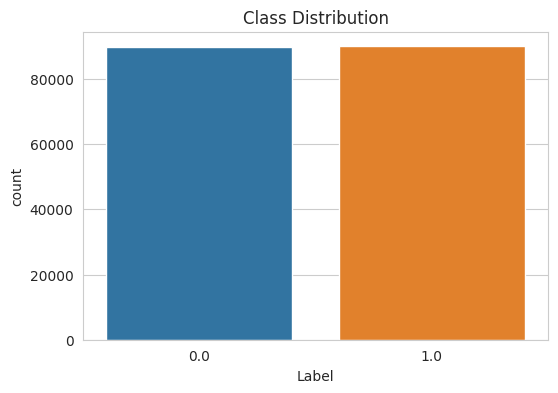

In [4]:
# EDA: Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df_train, x='Label')
plt.title('Class Distribution')
plt.show()

In [5]:
# Prepare train/val/test splits
X = df_train.drop(columns='Label')
y = df_train['Label']
X_test = df_test.drop(columns='Label')
y_test = df_test['Label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

del df_train, df_test
gc.collect()

2224

In [6]:
# Step 1: Variance Threshold
vt = VarianceThreshold(threshold=0.01)
X_train_vt = vt.fit_transform(X_train)
X_val_vt = vt.transform(X_val)
X_test_vt = vt.transform(X_test)

In [7]:
# Step 2: SelectKBest using ANOVA F-score
selector = SelectKBest(score_func=f_classif, k=800)
X_train_fs = selector.fit_transform(X_train_vt, y_train)
X_val_fs = selector.transform(X_val_vt)
X_test_fs = selector.transform(X_test_vt)

In [8]:
# Optional: Tree-Based Importance Filtering
rf_temp = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_temp.fit(X_train_fs, y_train)
importances = rf_temp.feature_importances_
top_idx = np.argsort(importances)[-500:]  # keep top 500

X_train_final = X_train_fs[:, top_idx]
X_val_final = X_val_fs[:, top_idx]
X_test_final = X_test_fs[:, top_idx]

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=100, num_leaves=31)
}

In [10]:
results = []

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_final, y_train)  # Make sure this is your final training data
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)  # Threshold at 0.5
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"{model_name} Performance:")
    print("Accuracy:", round(accuracy, 4))
    print("ROC AUC:", round(roc_auc, 4))
    print("Precision:", round(precision, 4))
    print("Recall:", round(recall, 4))
    print("F1 Score:", round(f1, 4))

# Convert results to DataFrame
results_df = pd.DataFrame(results).set_index('Model')


Training Logistic Regression...
Logistic Regression Performance:
Accuracy: 0.6039
ROC AUC: 0.645
Precision: 0.6109
Recall: 0.5723
F1 Score: 0.5909

Training Random Forest...
Random Forest Performance:
Accuracy: 0.9369
ROC AUC: 0.9862
Precision: 0.918
Recall: 0.9595
F1 Score: 0.9383

Training Gradient Boosting...
Gradient Boosting Performance:
Accuracy: 0.8609
ROC AUC: 0.9481
Precision: 0.816
Recall: 0.9319
F1 Score: 0.8701

Training XGBoost...
XGBoost Performance:
Accuracy: 0.9356
ROC AUC: 0.9844
Precision: 0.9256
Recall: 0.9474
F1 Score: 0.9363

Training LightGBM...
[LightGBM] [Info] Number of positive: 72012, number of negative: 71968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.540221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17158
[LightGBM] [Info] Number of data points in the train set: 143980, number of used features: 50

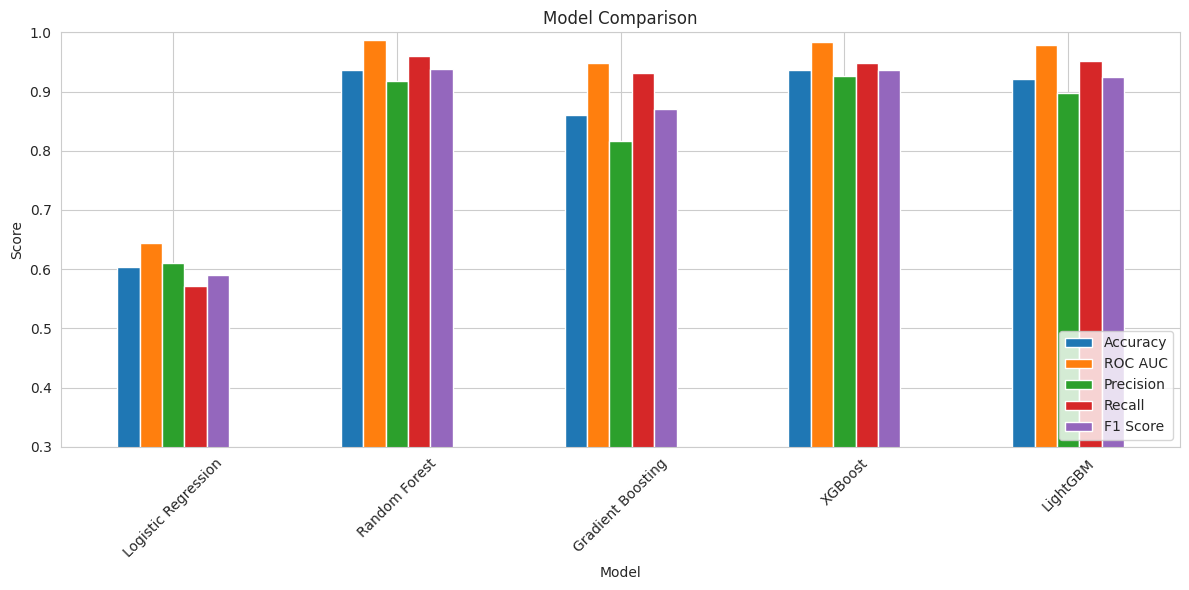

In [11]:
# Plotting
results_df.plot(kind='bar', figsize=(12, 6), rot=45)
plt.title("Model Comparison")
plt.ylabel("Score")
plt.ylim(0.3, 1.0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

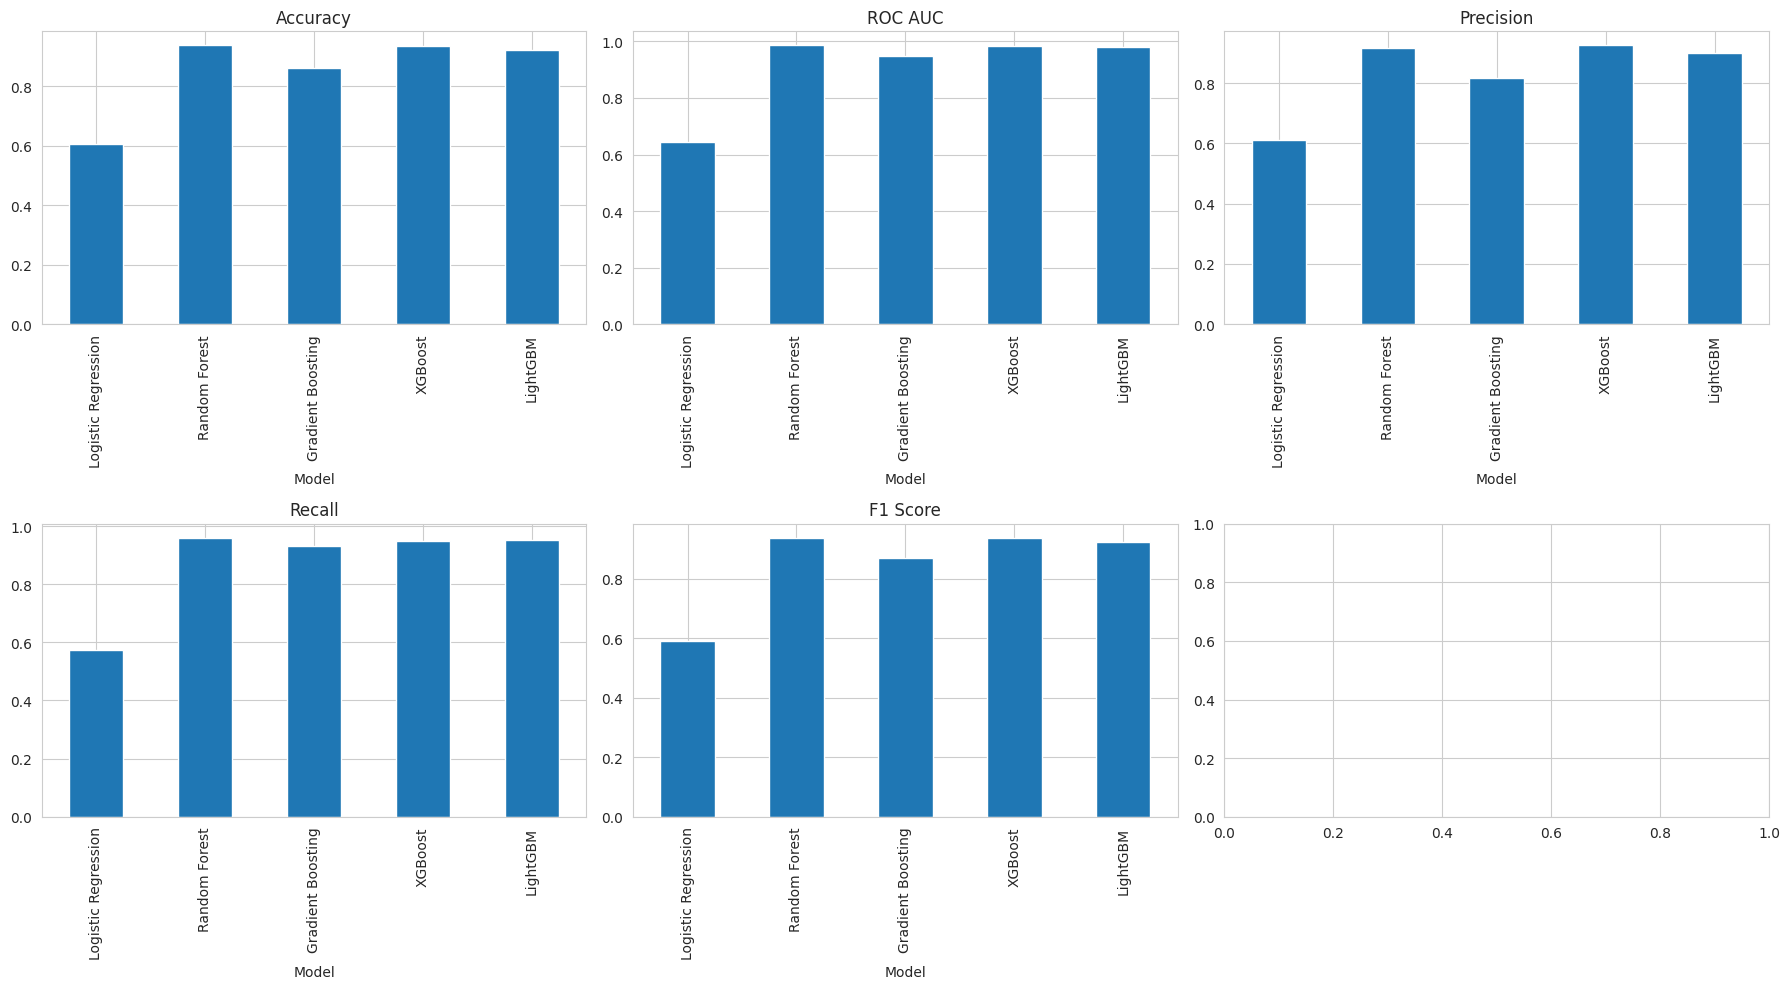

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics):
    results_df[[metric]].plot(kind='bar', ax=axes[i//3, i%3], title=metric, legend=False)
plt.tight_layout()
plt.show()

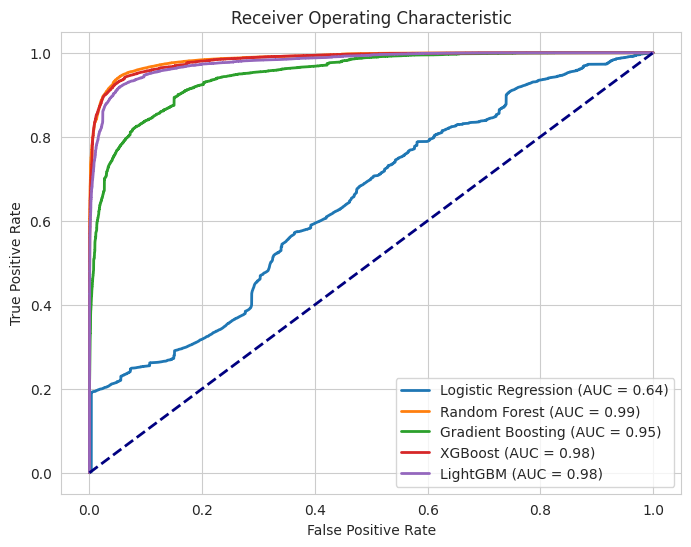

In [13]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for model_name, model in models.items():
    y_score = model.predict_proba(X_test_final)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

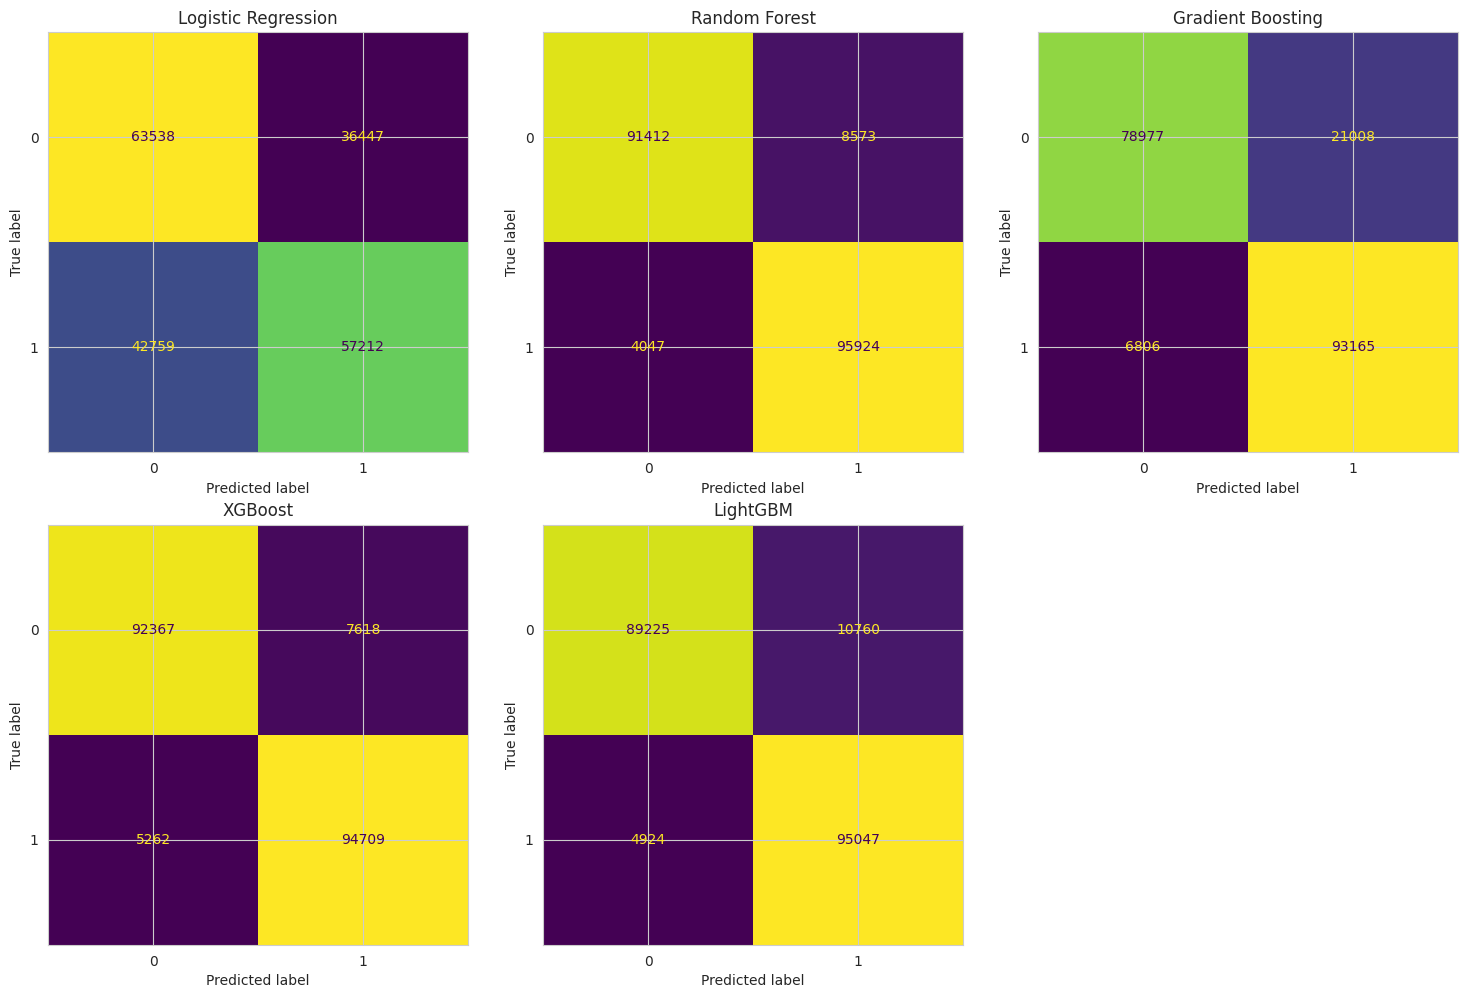

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define figure with subplots (adjust grid size based on number of models)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten to easily index

# Loop over each model and plot
for ax, (model_name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test_final)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(model_name)

# Hide any unused subplots if number of models < total subplots
for ax in axes[len(models):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
import joblib

joblib.dump(model, "ember_model.joblib")


['ember_model.joblib']

In [ ]:
joblib.dump(top_idx, "selected_feature_indices.joblib")
